# **Figures**

This notebook generates the figures shown in the paper.

In [1]:
import cv2

import pickle

import numpy as np
import pandas as pd

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from keras import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from tools import load_images_with_labels, calculate_metrics, save_metrics_to_csv

## Load data

In [2]:
#Image dimensions
width = 540
height = 960

#Paths where training, validation and test images are stored and organized by class
path = '../data/burn_images/' 
path_test = '../data/test_images/'

In [3]:
#Load images and their corresponding labels (using only the green channel)
X, y = load_images_with_labels(path=path, channels='green', width=width, height=height)

#Split the dataset into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [4]:
#Load the independent test set and their corresponding labels (using only the green channel)
X_test, y_test = load_images_with_labels(path=path_test, channels='green', width=width, height=height)

In [5]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (180, 960, 540, 1)
Shape of X_val: (45, 960, 540, 1)
Shape of X_test: (48, 960, 540, 1)
Shape of y_train: (180,)
Shape of y_val: (45,)
Shape of y_test: (48,)


In [6]:
#Number of samples per class in each dataset
print('Training:', Counter(y_train))
print('Validation:', Counter(y_val))
print('Test:', Counter(y_test))

Training: Counter({0: 97, 1: 83})
Validation: Counter({1: 28, 0: 17})
Test: Counter({0: 24, 1: 24})


## Load model and history

In [7]:
#Load the trained proposed CNN model
cnn = models.load_model('../models/proposed_model/burn_green_cnn.keras')

In [8]:
#Load the training history
with open('../models/proposed_model/burn_green_cnn_history.pkl', 'rb') as f:
    history = pickle.load(f)

### Plot training and validation accuracy and loss curves

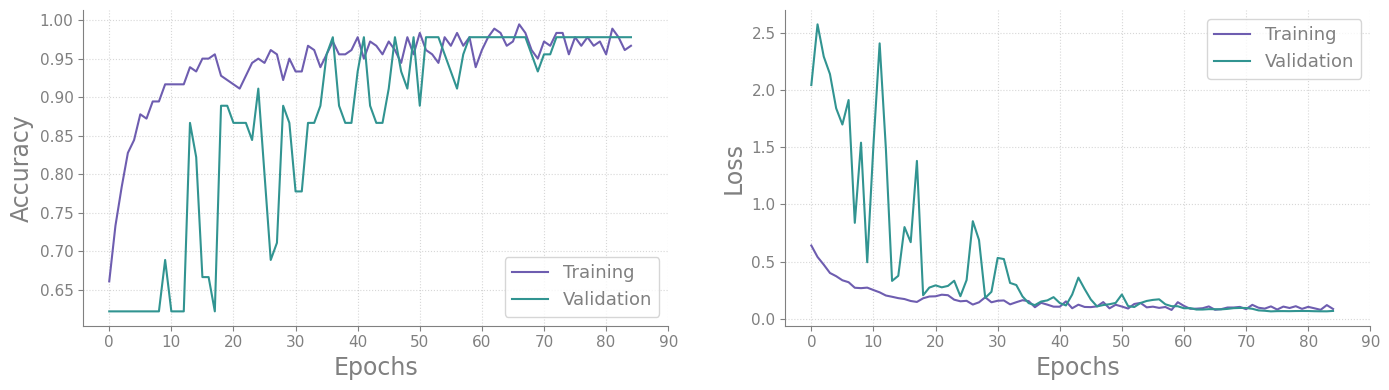

In [9]:
color_train = '#6e5db0' #Color for the training curves
color_val = '#319491' #Color for the validation curves

#Extract metrics from training history
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

#Define epoch range and tick positions
epochs_range = range(len(train_acc))
ticks = list(range(0, len(train_acc)+6, 10))

#Create figure with two subplots (accuracy and loss)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4)) 

#Accuracy
ax1.plot(epochs_range, train_acc, label='Training', color=color_train)
ax1.plot(epochs_range, val_acc, label='Validation', color=color_val)
ax1.set_ylabel('Accuracy', fontsize=17, color='gray')

#Loss
ax2.plot(epochs_range, train_loss, label='Training', color=color_train)
ax2.plot(epochs_range, val_loss, label='Validation', color=color_val)
ax2.set_ylabel('Loss', fontsize=17, color='gray')

#Apply consistent formatting to both subplots
for ax in (ax1, ax2):
    ax.set_xlabel('Epochs', fontsize=17, color='gray')
    ax.set_xticks(ticks)
    ax.tick_params(axis='both', labelsize=11, colors='gray')
    ax.legend(fontsize=13, labelcolor='gray')
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')

#Adjust layout and save figure
plt.tight_layout()
plt.subplots_adjust(wspace=0.2) 
plt.savefig('../figures/3b_accuracy_loss.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot confusion matrices for training, validation, and test sets in a single figure

In [10]:
def adjust_annotation_colors(hm, ax, data, threshold=0.7, light_color='white', dark_color='gray'):
    '''
    Function that adjusts annotation text colors inside the heatmap for better contrast. 
    Text is shown in gray on light backgrounds and in white on dark backgrounds.

    Parameters:
    - hm (seaborn.matrix.ClusterGrid or matplotlib.collections.QuadMesh): Heatmap object returned by seaborn.heatmap().
    - ax (matplotlib.axes.Axes): Axes object containing the heatmap.
    - data (numpy.ndarray): 2D array used to generate the heatmap (e.g., confusion matrix values).
    - threshold (float): Luminance threshold used to determine whether the background is considered dark.
    - light_color (str): Text color used when the background is dark.
    - dark_color (str): Text color used when the background is light.

    Returns:
    - None. The function modifies the annotation text colors in-place.
    '''
    mesh = hm.collections[0] #Retrieve the QuadMesh object that represents the heatmap cells
    norm = mesh.norm #norm maps data values to the [0, 1] range
    cmap = mesh.cmap #cmap maps normalized values to RGBA colors

    #Adjust annotation text color based on cell luminance
    for text, val in zip(ax.texts, data.flatten()):
        r, g, b, _ = cmap(norm(val))
        luminance = 0.299*r + 0.587*g + 0.114*b
        if luminance < threshold:
            text.set_color(light_color)
        else:
            text.set_color(dark_color)

    #Set colorbar tick labels to gray
    if mesh.colorbar is not None:
        mesh.colorbar.ax.tick_params(labelcolor='gray', color='gray')

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step


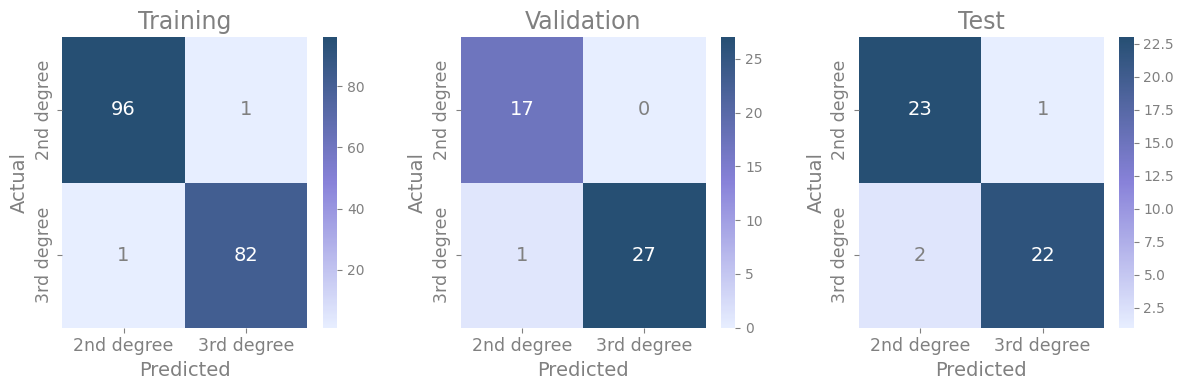

In [11]:
#Compute performance metrics for each dataset split
cm_train, acc_train, prec_train, rec_train, f1_train = calculate_metrics(cnn, X_train, y_train)
cm_val, acc_val, prec_val, rec_val, f1_val = calculate_metrics(cnn, X_val, y_val)
cm_test, acc_test, prec_test, rec_test, f1_test = calculate_metrics(cnn, X_test, y_test)

#Define a custom color gradient for heatmap visualization
colors = ['#e7eeff', '#8882d9', '#264f73']
custom_cmap = LinearSegmentedColormap.from_list('custom_bupu', colors)

labels = ['2nd degree', '3rd degree'] #Class lables

#Create figure with three subplots (training, validation, test)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

#Training
hm_train = sns.heatmap(cm_train, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels, 
                       ax=ax1, annot_kws={'size': 14})
ax1.set_title('Training', fontsize=17, color='gray')
adjust_annotation_colors(hm_train, ax1, cm_train, threshold=0.7, light_color='white', dark_color='gray')

#Validation
hm_val = sns.heatmap(cm_val, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels, 
                     ax=ax2, annot_kws={'size': 14})
ax2.set_title('Validation', fontsize=17, color='gray')
adjust_annotation_colors(hm_val, ax2, cm_val, threshold=0.7, light_color='white', dark_color='gray')

#Test
hm_test = sns.heatmap(cm_test, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels, 
                      ax=ax3, annot_kws={'size': 14})
ax3.set_title('Test', fontsize=17, color='gray')
adjust_annotation_colors(hm_test, ax3, cm_test, threshold=0.7, light_color='white', dark_color='gray')

#Apply consistent formatting to to all confusion matrices
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Predicted', fontsize=14, color='gray')
    ax.set_ylabel('Actual', fontsize=14, color='gray')
    ax.set_xticklabels(ax.get_xticklabels(), color='gray')
    ax.set_yticklabels(ax.get_yticklabels(), color='gray')
    ax.tick_params(labelsize=12.5, color='gray')

#Adjust layout and save figure
plt.tight_layout()
plt.subplots_adjust(wspace=0.3) 
plt.savefig('../figures/3c_confusion_matrix_train_val_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
#Save training and validation evaluation metrics to a CSV file
save_metrics_to_csv(cnn, X_train, y_train, 'OurModel', 'train', '../data/results/model_metrics.csv')
save_metrics_to_csv(cnn, X_val, y_val, 'OurModel', 'val', '../data/results/model_metrics.csv')

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step


### Plot per-class evaluation metrics for training, validation, and test sets in a single figure

In [13]:
def calculate_class_metrics(model, X, y):
    '''
    Function that computes per-class classification metrics for a given dataset.

    Parameters:
    - model (keras.Model): Trained keras model with a 'predict' method.
    - X (np.ndarray): Input dataset.
    - y (np.ndarray): Labels associated with the input data..

    Returns:
    - (pandas.DataFrame): DataFrame containing per-class accuracy, precision, recall, and f1-score.
                          Rows correspond to classes.
    '''
    predictions = model.predict(X) #Model predictions

    y_true = y.flatten() #Flatten labels to ensure compatibility
    y_pred = (predictions > 0.5).astype(int).flatten() #Convert probabilities to binary classes. Probability > 0.5 corresponds to third degree (class 1)

    CM = confusion_matrix(y_true, y_pred) #Compute confusion matrix
    precision_clase, recall_clase, f1_clase, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0) #Compute precision, recall, and F1-score per class
    accuracy_clase = CM.diagonal() / CM.sum(axis=1) #Compute per-class accuracy (true positives divided by total samples per class)

    #Return metrics as a structured DataFrame
    return pd.DataFrame({
        'Accuracy': accuracy_clase,
        'Precision': precision_clase,
        'Recall': recall_clase,
        'F1-Score': f1_clase
    }, index=['2nd degree', '3rd degree'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step


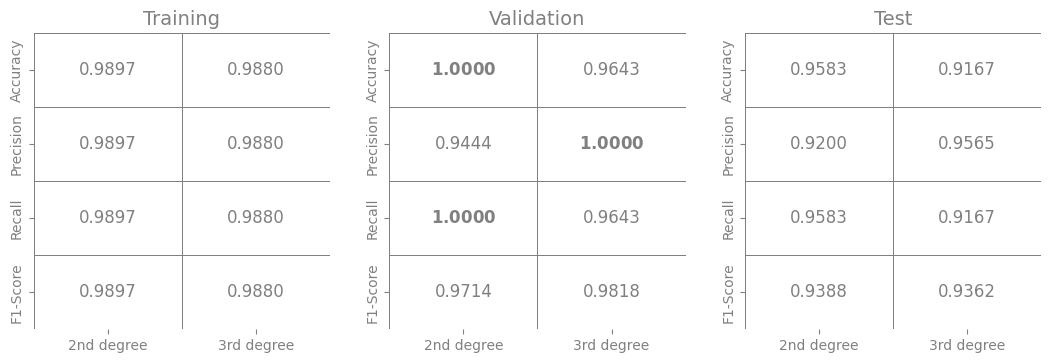

In [14]:
#Compute per-class metrics for each dataset split
df_train_class_metrics = calculate_class_metrics(cnn, X_train, y_train)
df_val_class_metrics = calculate_class_metrics(cnn, X_val, y_val)
df_test_class_metrics = calculate_class_metrics(cnn, X_test, y_test)

#Format annotations: highlight perfect scores (1.0000) in bold for emphasis
annot_train = df_train_class_metrics.T.apply(lambda col: col.map(lambda x: r'$\bf{1.0000}$' if np.isclose(x, 1.0) else f'{x:.4f}'))
annot_val = df_val_class_metrics.T.apply(lambda col: col.map(lambda x: r'$\bf{1.0000}$' if np.isclose(x, 1.0) else f'{x:.4f}'))
annot_test = df_test_class_metrics.T.apply(lambda col: col.map(lambda x: r'$\bf{1.0000}$' if np.isclose(x, 1.0) else f'{x:.4f}'))

#Create figure with three subplots (training, validation, test)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))

#Training
sns.heatmap(df_train_class_metrics.T, annot=annot_train, fmt='', cmap='Greys', vmin=1, vmax=1,
            linewidths=0.5, linecolor='gray', cbar=False, ax=ax1, annot_kws={'size': 12, 'color': 'gray'})
ax1.set_title('Training', fontsize=14, color='gray')

#Validation
sns.heatmap(df_val_class_metrics.T, annot=annot_val, fmt='', cmap='Greys', vmin=1, vmax=1,
            linewidths=0.5, linecolor='gray', cbar=False, ax=ax2, annot_kws={'size': 12, 'color': 'gray'})
ax2.set_title('Validation', fontsize=14, color='gray')

#Test
sns.heatmap(df_test_class_metrics.T, annot=annot_test, fmt='', cmap='Greys', vmin=1, vmax=1,
            linewidths=0.5, linecolor='gray', cbar=False, ax=ax3, annot_kws={'size': 12, 'color': 'gray'})
ax3.set_title('Test', fontsize=14, color='gray')

#Apply consistent formatting to all subplots
for ax in (ax1, ax2, ax3):
    ax.set_xticklabels(ax.get_xticklabels(), color='gray')
    ax.set_yticklabels(ax.get_yticklabels(), color='gray')
    ax.tick_params(labelsize=10, color='gray')

#Adjust layout and save figure
plt.subplots_adjust(wspace=0.2, top=0.85) 
plt.savefig('../figures/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### Heatmap of evaluation metrics for all models trained in the hyperparameter search

In [15]:
def best_model_bold(best_model_name, model_names, ax, hm, n_cols):
    '''
    Highlight the best-performing model in the heatmap by rendering its
    row label and corresponding metric values in bold.

    Parameters:
    - best_model_name (str): Name of the model to highlight.
    - model_names (numpy.ndarray): Array containing the names of all evaluated models.
    - ax (matplotlib.axes.Axes): Axes object containing the heatmap.
    - hm (seaborn.matrix.ClusterGrid or matplotlib.collections.QuadMesh): Heatmap object returned by seaborn.heatmap().
    - n_cols (int): Number of metric columns in the heatmap (used to compute row index).

    Returns:
    - None. The function modifies tick labels and annotations in-place.
    '''
    #Bold the y-axis label corresponding to the best model
    for tick_label in ax.get_yticklabels():
        if tick_label.get_text() == best_model_name:
            tick_label.set_fontweight('bold')

    #Bold the annotation values (heatmap cells) corresponding to the best model row
    for i, text in enumerate(hm.texts):
        row = i // n_cols
        if row == np.where(model_names == best_model_name)[0][0]:
            text.set_fontweight('bold')

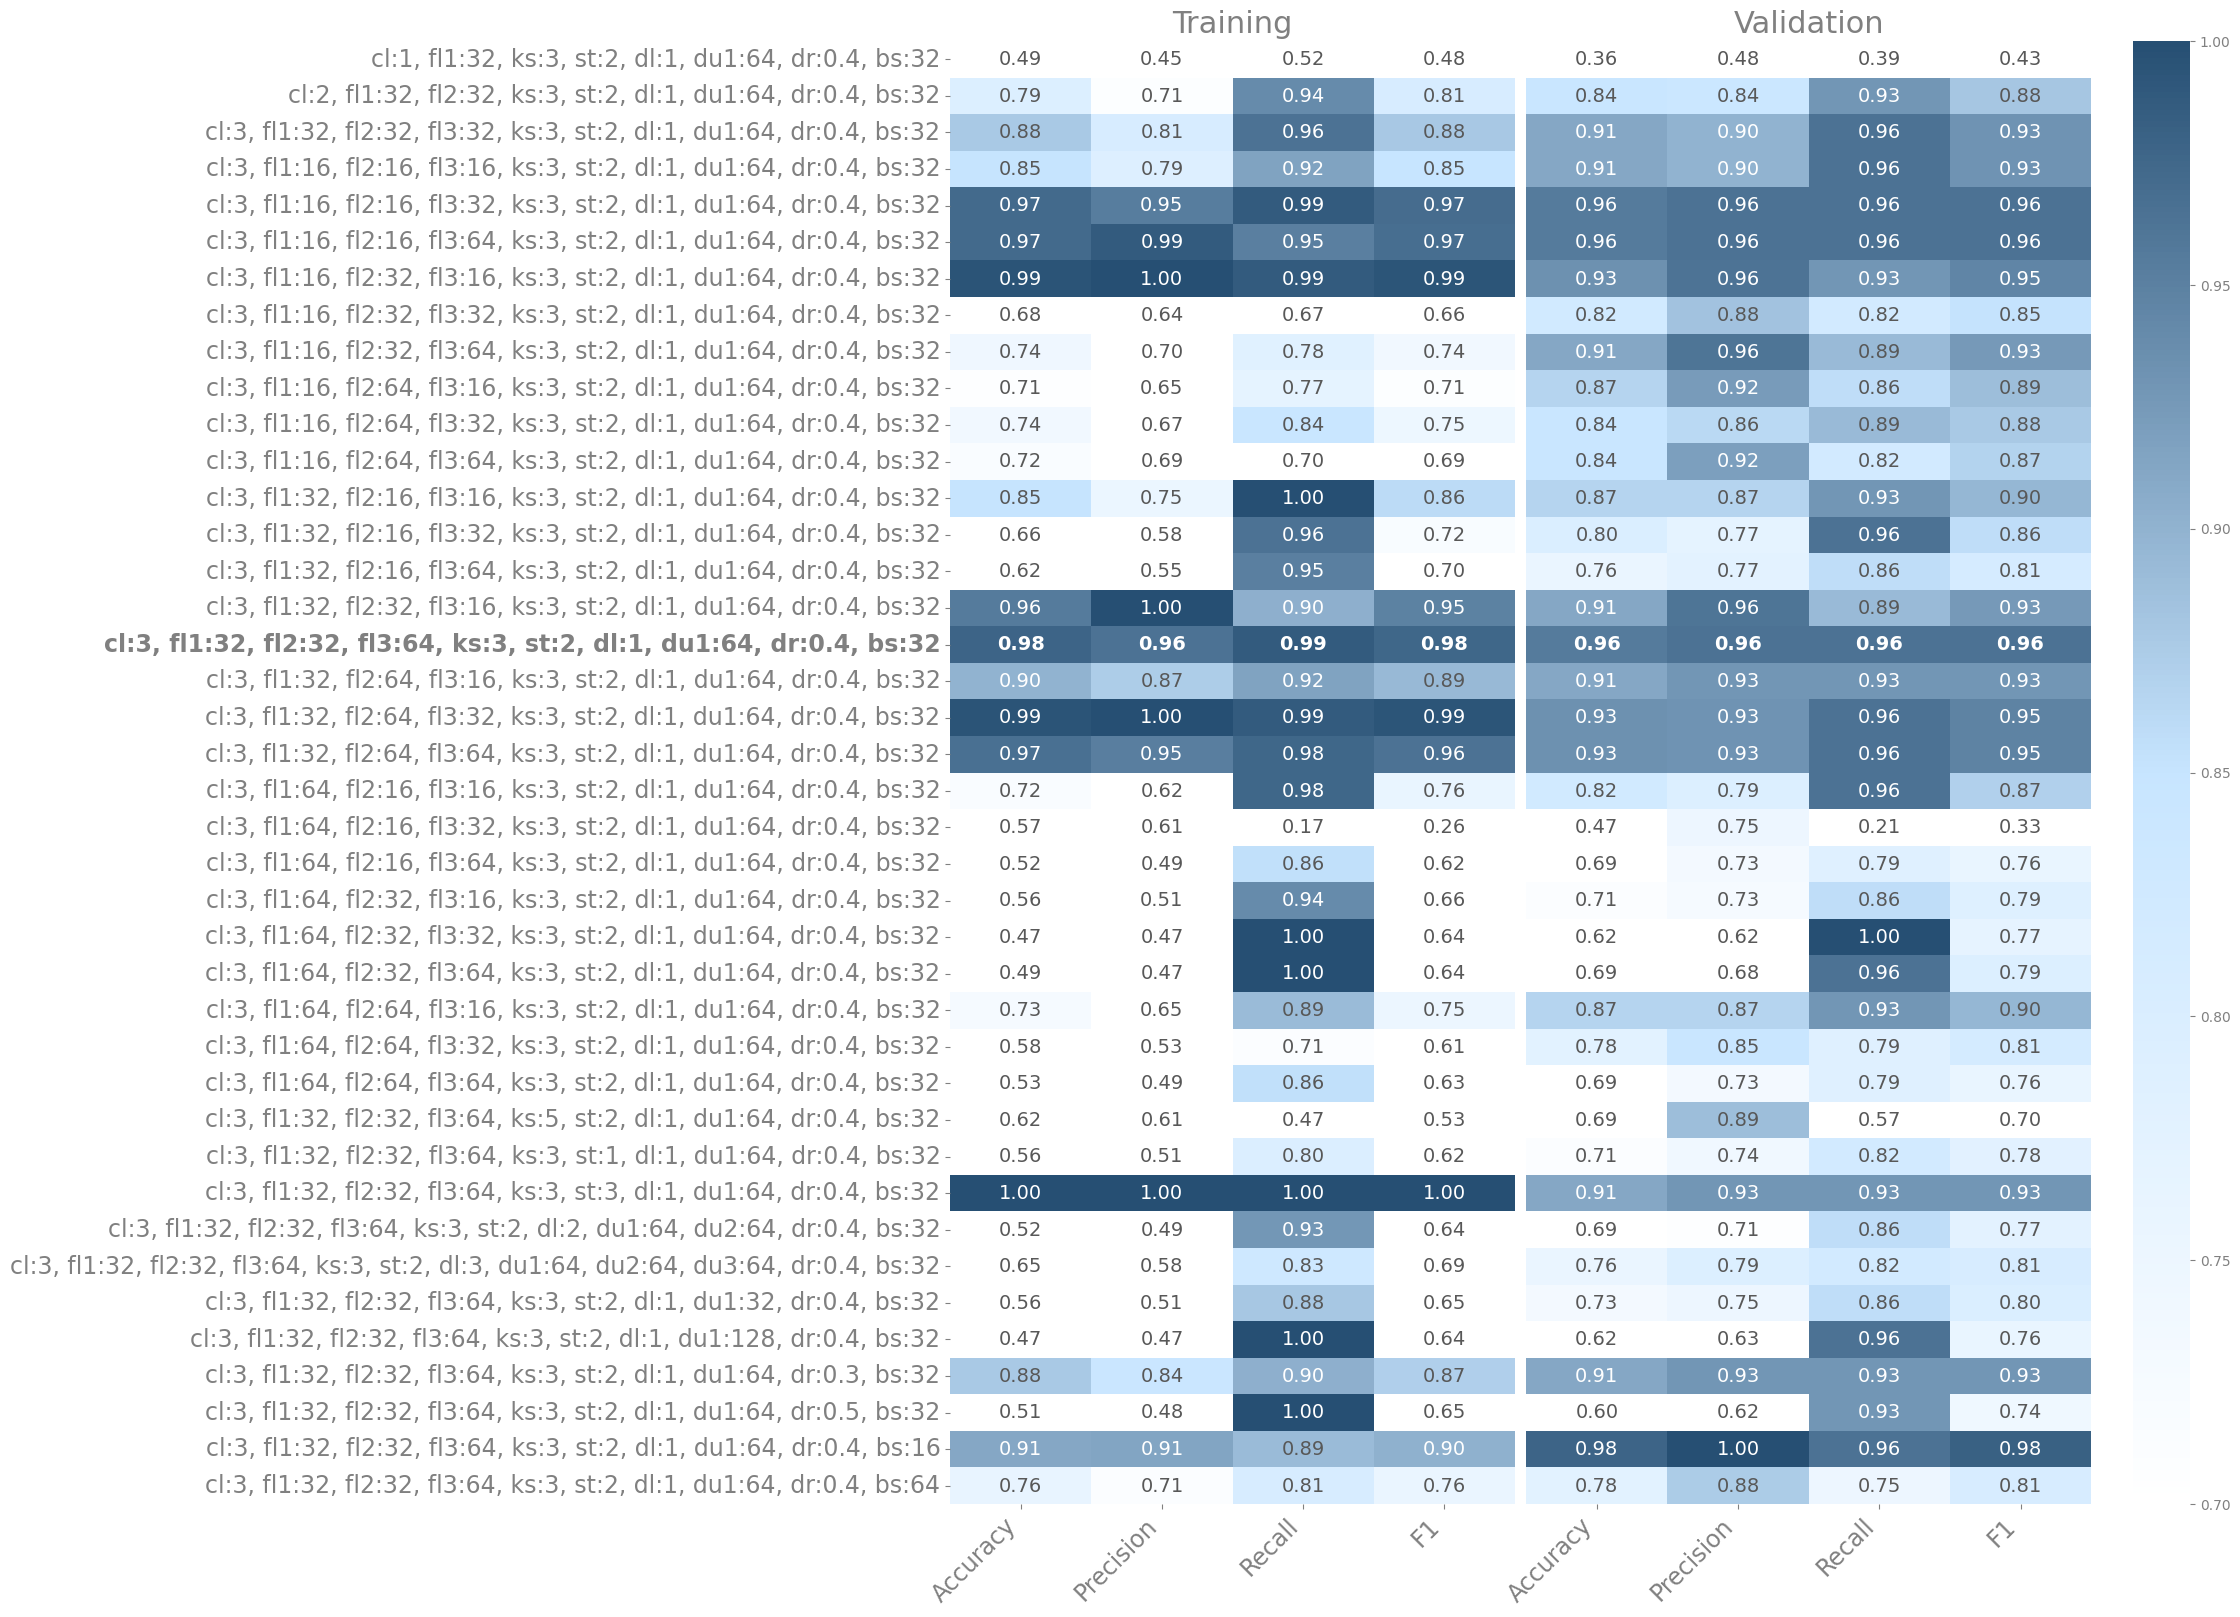

In [16]:
df = pd.read_csv('../data/results/hyperparameter_search.csv') #Load hyperparameter search results

metrics = ['Accuracy', 'Precision', 'Recall', 'F1'] #Define the evaluation metrics

#Generate column names corresponding to training and validation results
train_metrics = [f'{m} Training' for m in metrics]
val_metrics = [f'{m} Validation' for m in metrics]

#Extract metric values from the df as numpy arrays
data_train = df[train_metrics].values
data_val = df[val_metrics].values

#Retrieve model configuration names (each row corresponds to one trained model)
model_names = df['Name'].values

#Define a custom color gradient for heatmap visualization
colors = ['#ffffff', '#c7e5ff', '#264f73']
custom_cmap = LinearSegmentedColormap.from_list('custom_blue', colors)

#Create figure with GridSpec layout (two heatmaps of equal width and a dedicated axis for the colorbar)
fig = plt.figure(figsize=(16, 19))

gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], wspace=0.07) #Main grid: heatmaps + colorbar
gs_hm = gs[0].subgridspec(1, 2, wspace=0.02) #Grid only for heatmaps (controls their separation)

ax1 = fig.add_subplot(gs_hm[0]) #Training metrics heatmap
ax2 = fig.add_subplot(gs_hm[1]) #Validation metrics heatmap
cax = fig.add_subplot(gs[1]) #Dedicated axis for the shared colorbar

#Training
hm_train = sns.heatmap(data_train, annot=True, fmt='.2f', cmap=custom_cmap, vmin=0.7, vmax=1.0,
                       xticklabels=metrics, yticklabels=model_names, ax=ax1, cbar=False, annot_kws={'size': 14})
ax1.set_title('Training', fontsize=22, color='gray')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=17, color='gray')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=17, color='gray')
ax1.tick_params(axis='both', color='gray')
adjust_annotation_colors(hm_train, ax1, data_train, threshold=0.68, light_color='white', dark_color='#585858')
best_model_bold('cl:3, fl1:32, fl2:32, fl3:64, ks:3, st:2, dl:1, du1:64, dr:0.4, bs:32', model_names, ax1, hm_train, n_cols=len(metrics))

#Validation
hm_val = sns.heatmap(data_val, annot=True, fmt='.2f', cmap=custom_cmap, vmin=0.7, vmax=1.0,
                     xticklabels=metrics, yticklabels=False, ax=ax2, cbar_ax=cax, annot_kws={'size': 14})
ax2.set_title('Validation', fontsize=22, color='gray')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=17, color='gray')
ax2.tick_params(axis='both', color='gray')
adjust_annotation_colors(hm_val, ax2, data_val, threshold=0.68, light_color='white', dark_color='#585858')
best_model_bold('cl:3, fl1:32, fl2:32, fl3:64, ks:3, st:2, dl:1, du1:64, dr:0.4, bs:32', model_names, ax2, hm_val, n_cols=len(metrics))

#Save figure
plt.savefig('../figures/2a_heatmap_hyperparameter_search.png', dpi=300, bbox_inches='tight')
plt.show()

### Heatmap of evaluation metrics for models trained with each channel combination

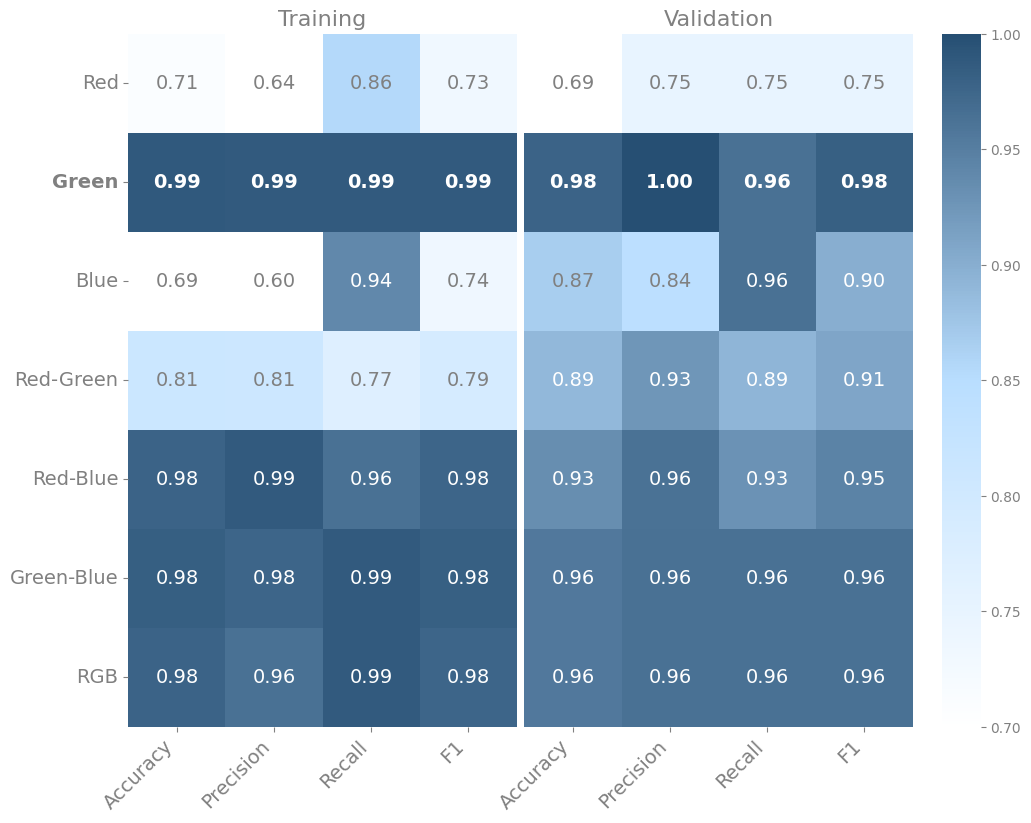

In [17]:
df = pd.read_csv('../data/results/channel_analysis.csv') #Load channel analysis results

metrics = ['Accuracy', 'Precision', 'Recall', 'F1'] #Define the evaluation metrics

#Generate column names corresponding to training and validation results
train_metrics = [f'{m} Training' for m in metrics]
val_metrics = [f'{m} Validation' for m in metrics]

#Extract metric values from the df as numpy arrays
data_train = df[train_metrics].values
data_val = df[val_metrics].values

#Retrieve model configuration names (each row corresponds to one trained model)
model_names = df['Name'].values

#Define a custom color gradient for heatmap visualization
colors = ['#ffffff', '#b9deff', '#264f73']
custom_cmap = LinearSegmentedColormap.from_list('custom_blue', colors)

#Create figure with GridSpec layout (two heatmaps of equal width and a dedicated axis for the colorbar)
fig = plt.figure(figsize=(11, 9))

gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], wspace=0.07) #Main grid: heatmaps + colorbar
gs_hm = gs[0].subgridspec(1, 2, wspace=0.02) #Grid only for heatmaps (controls their separation)

ax1 = fig.add_subplot(gs_hm[0]) #Training metrics heatmap
ax2 = fig.add_subplot(gs_hm[1]) #Validation metrics heatmap
cax = fig.add_subplot(gs[1]) #Dedicated axis for the shared colorbar

#Training
hm_train = sns.heatmap(data_train, annot=True, fmt='.2f', cmap=custom_cmap, vmin=0.7, vmax=1.0,
                       xticklabels=metrics, yticklabels=model_names, ax=ax1, cbar=False, annot_kws={'size': 14})
ax1.set_title('Training', fontsize=16, color='gray')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=14, color='gray')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=14, color='gray')
ax1.tick_params(axis='both', color='gray')
adjust_annotation_colors(hm_train, ax1, data_train, threshold=0.7, light_color='white', dark_color='gray')
best_model_bold('Green', model_names, ax1, hm_train, n_cols=len(metrics))

#Validation
hm_val = sns.heatmap(data_val, annot=True, fmt='.2f', cmap=custom_cmap, vmin=0.7, vmax=1.0,
                     xticklabels=metrics, yticklabels=False, ax=ax2, cbar_ax=cax, annot_kws={'size': 14})
ax2.set_title('Validation', fontsize=16, color='gray')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=14, color='gray')
ax2.tick_params(axis='both', color='gray')
adjust_annotation_colors(hm_val, ax2, data_val, threshold=0.7, light_color='white', dark_color='gray')
best_model_bold('Green', model_names, ax2, hm_val, n_cols=len(metrics))

#Save figure
plt.savefig('../figures/3a_heatmap_channel_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure 1. Example images from the dataset

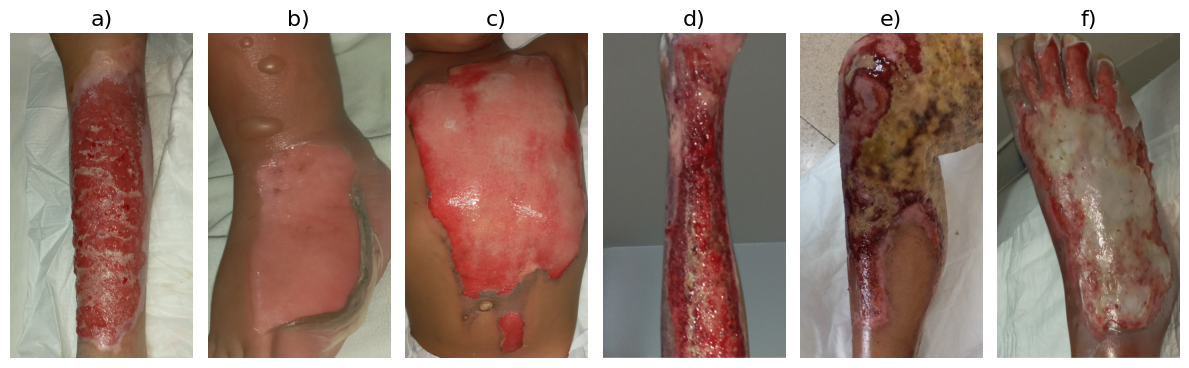

In [18]:
#Load representative second degree burn images
img1 = cv2.imread('../data/burn_images/second_degree/23_grado_2.jpg')
img2 = cv2.imread('../data/burn_images/second_degree/32_grado_2.jpg')
img3 = cv2.imread('../data/burn_images/second_degree/100_grado_2.jpg')

#Load representative thirddegree burn images
img4 = cv2.imread('../data/burn_images/third_degree/19_grado_3.jpg')
img5 = cv2.imread('../data/burn_images/third_degree/44_grado_3.jpg')
img6 = cv2.imread('../data/burn_images/third_degree/101_grado_3.jpg')

#Create a figure with six horizontally arranged subplots
fig, ax = plt.subplots(1, 6, figsize=(12, 20))

#Display second degree burn examples
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].set_title('a)', fontsize='16')
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].set_title('b)', fontsize='16')
ax[1].axis('off')

ax[2].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax[2].set_title('c)', fontsize='16')
ax[2].axis('off')

#Display third degree burn examples
ax[3].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
ax[3].set_title('d)', fontsize='16')
ax[3].axis('off')

ax[4].imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
ax[4].set_title('e)', fontsize='16')
ax[4].axis('off')

ax[5].imshow(cv2.cvtColor(img6, cv2.COLOR_BGR2RGB))
ax[5].set_title('f)', fontsize='16')
ax[5].axis('off')

#Adjust layout and save figure
plt.tight_layout()
plt.savefig('../figures/figure_1.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure 2. Hyperparameter search results (heatmap and best architecture)

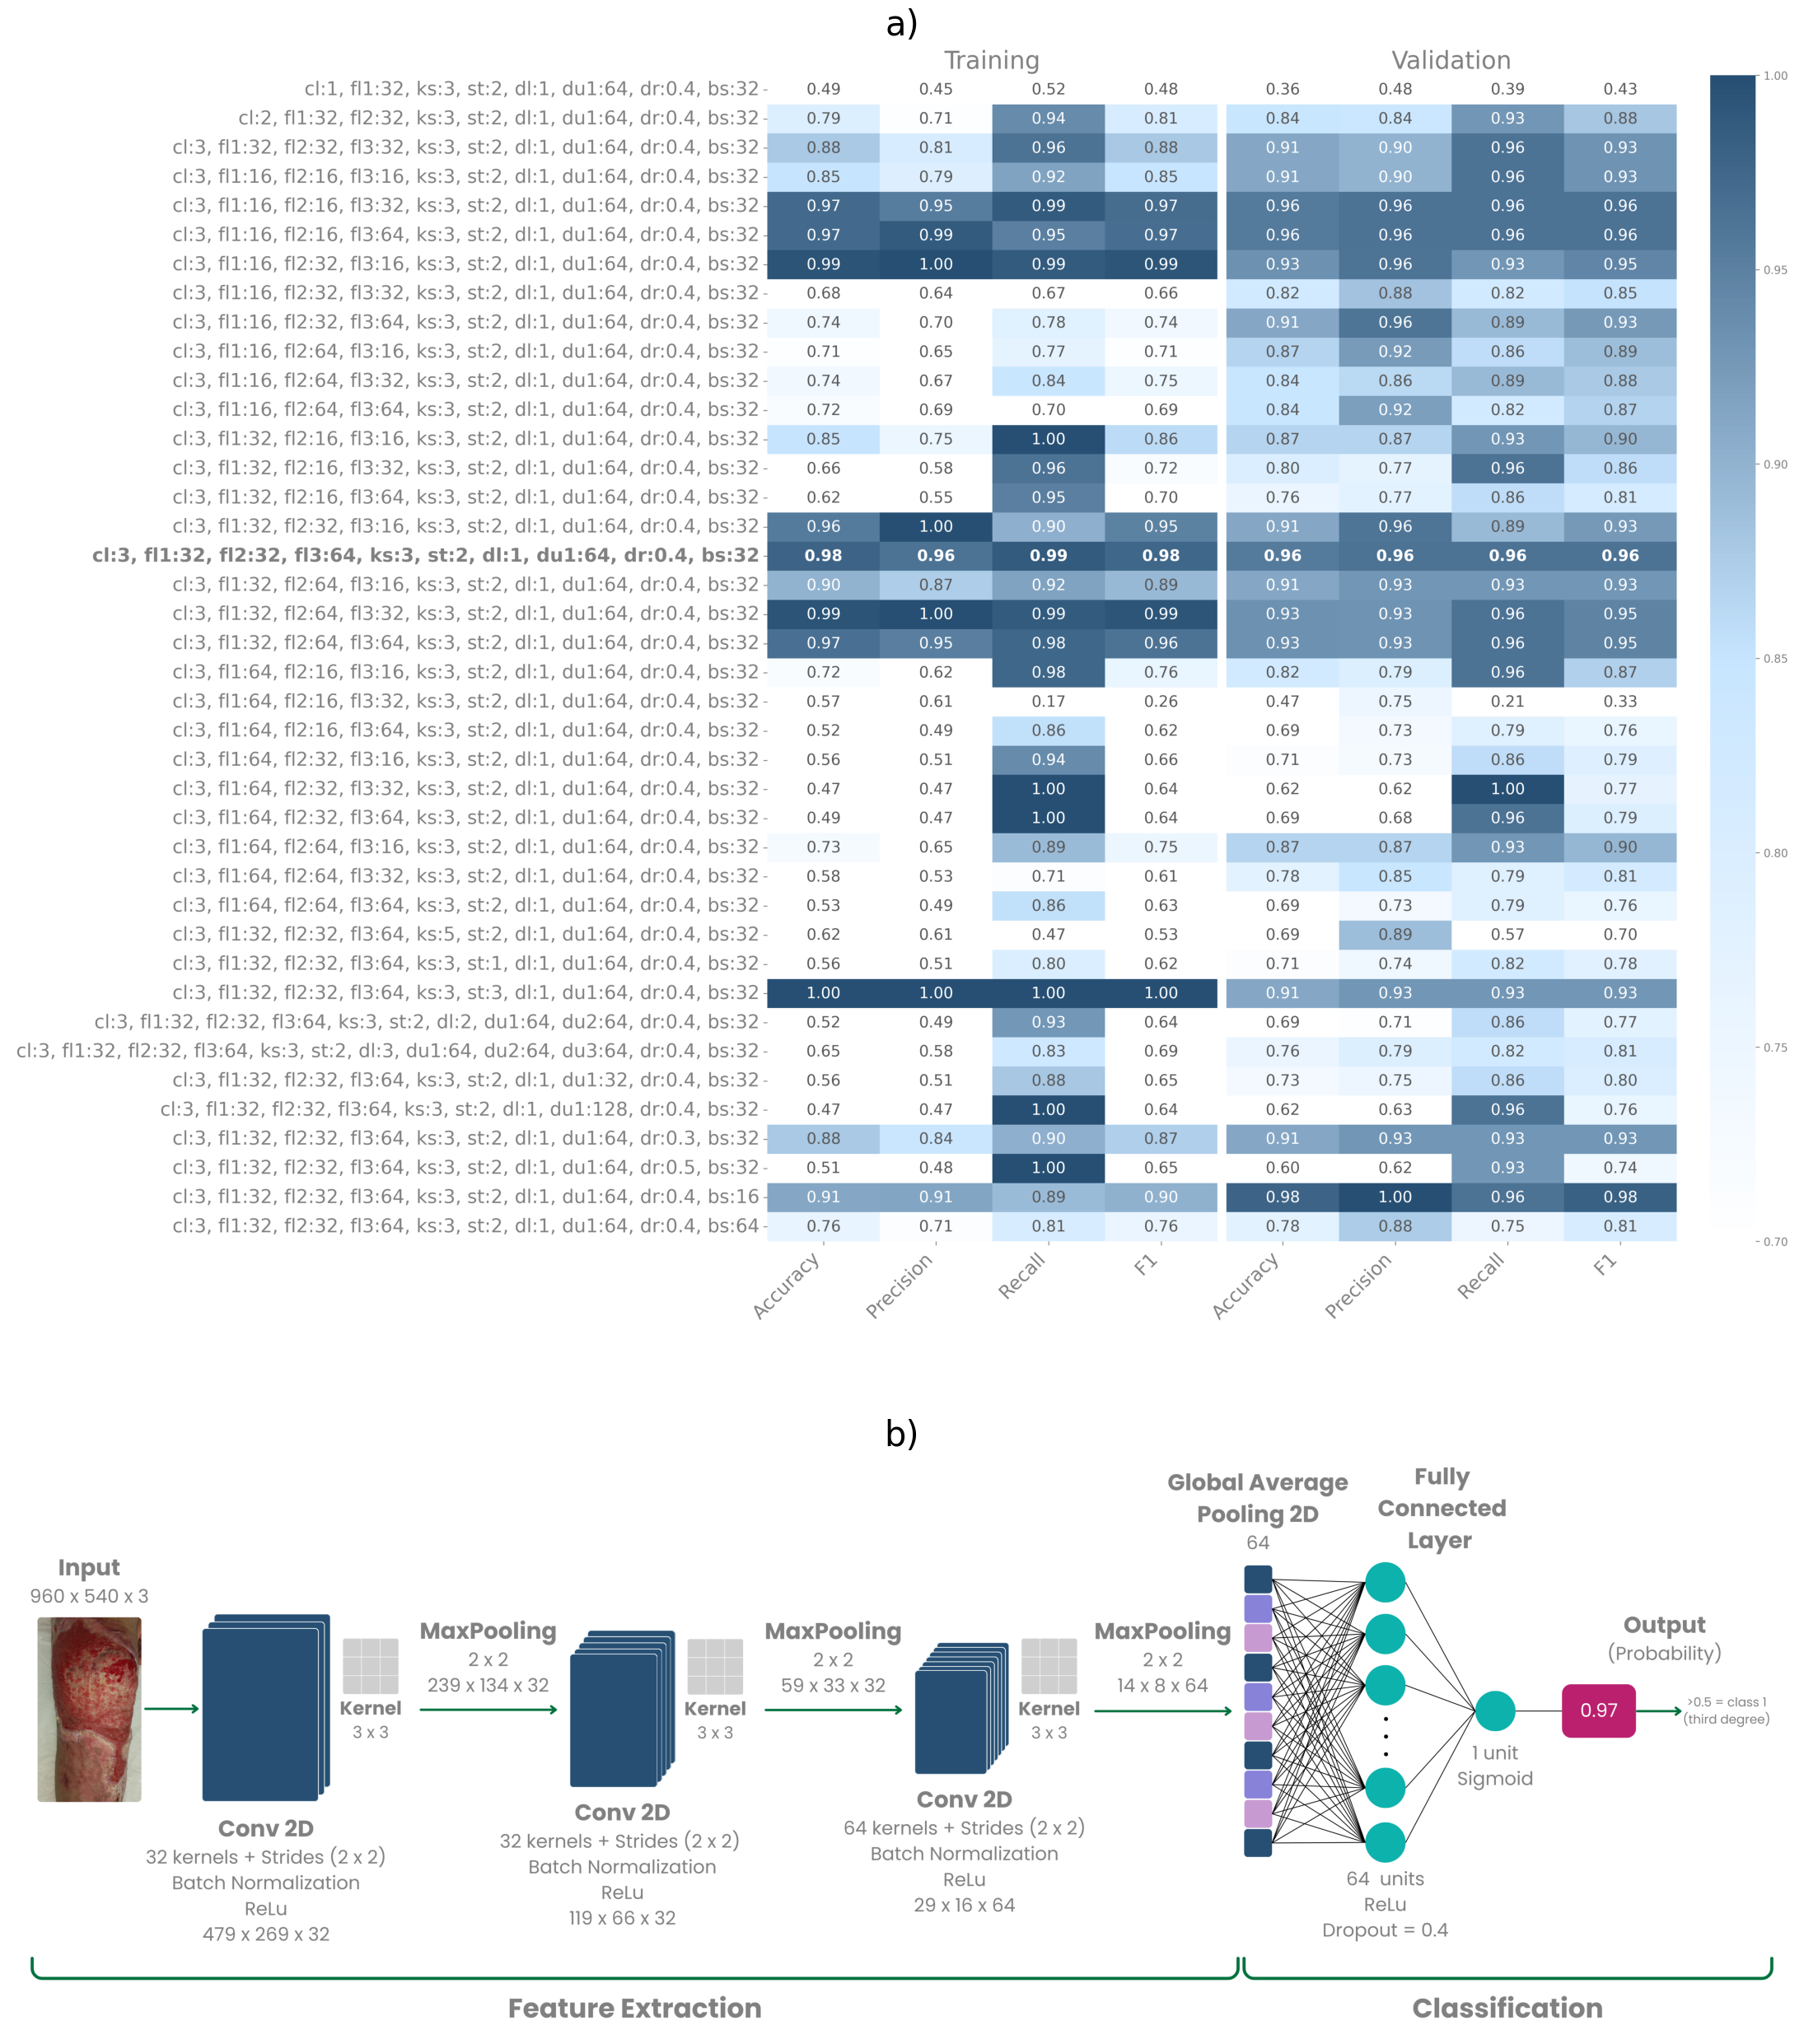

In [19]:
#Load previously generated figures
img_a = cv2.imread('../figures/2a_heatmap_hyperparameter_search.png')
img_b = cv2.imread('../figures/2b_architecture_hyperparameter_search.png')

#Create a vertically stacked figure with two panels (the first panel (heatmap) is given more vertical space)
fig, ax = plt.subplots(2, 1, figsize=(22, 27), gridspec_kw={'height_ratios': [1.4, 1]})

#(a) Hyperparameter search heatmap
ax[0].imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB))
ax[0].set_title('a)', fontsize='30')
ax[0].axis('off')

#(b) Best architecture
ax[1].imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
ax[1].set_title('b)', fontsize='30')
ax[1].axis('off')

#Adjust layout and save figure
plt.tight_layout()
plt.savefig('../figures/figure_2.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure 3. Channel analysis (metrics heatmap, learning curves, and confusion matrices)

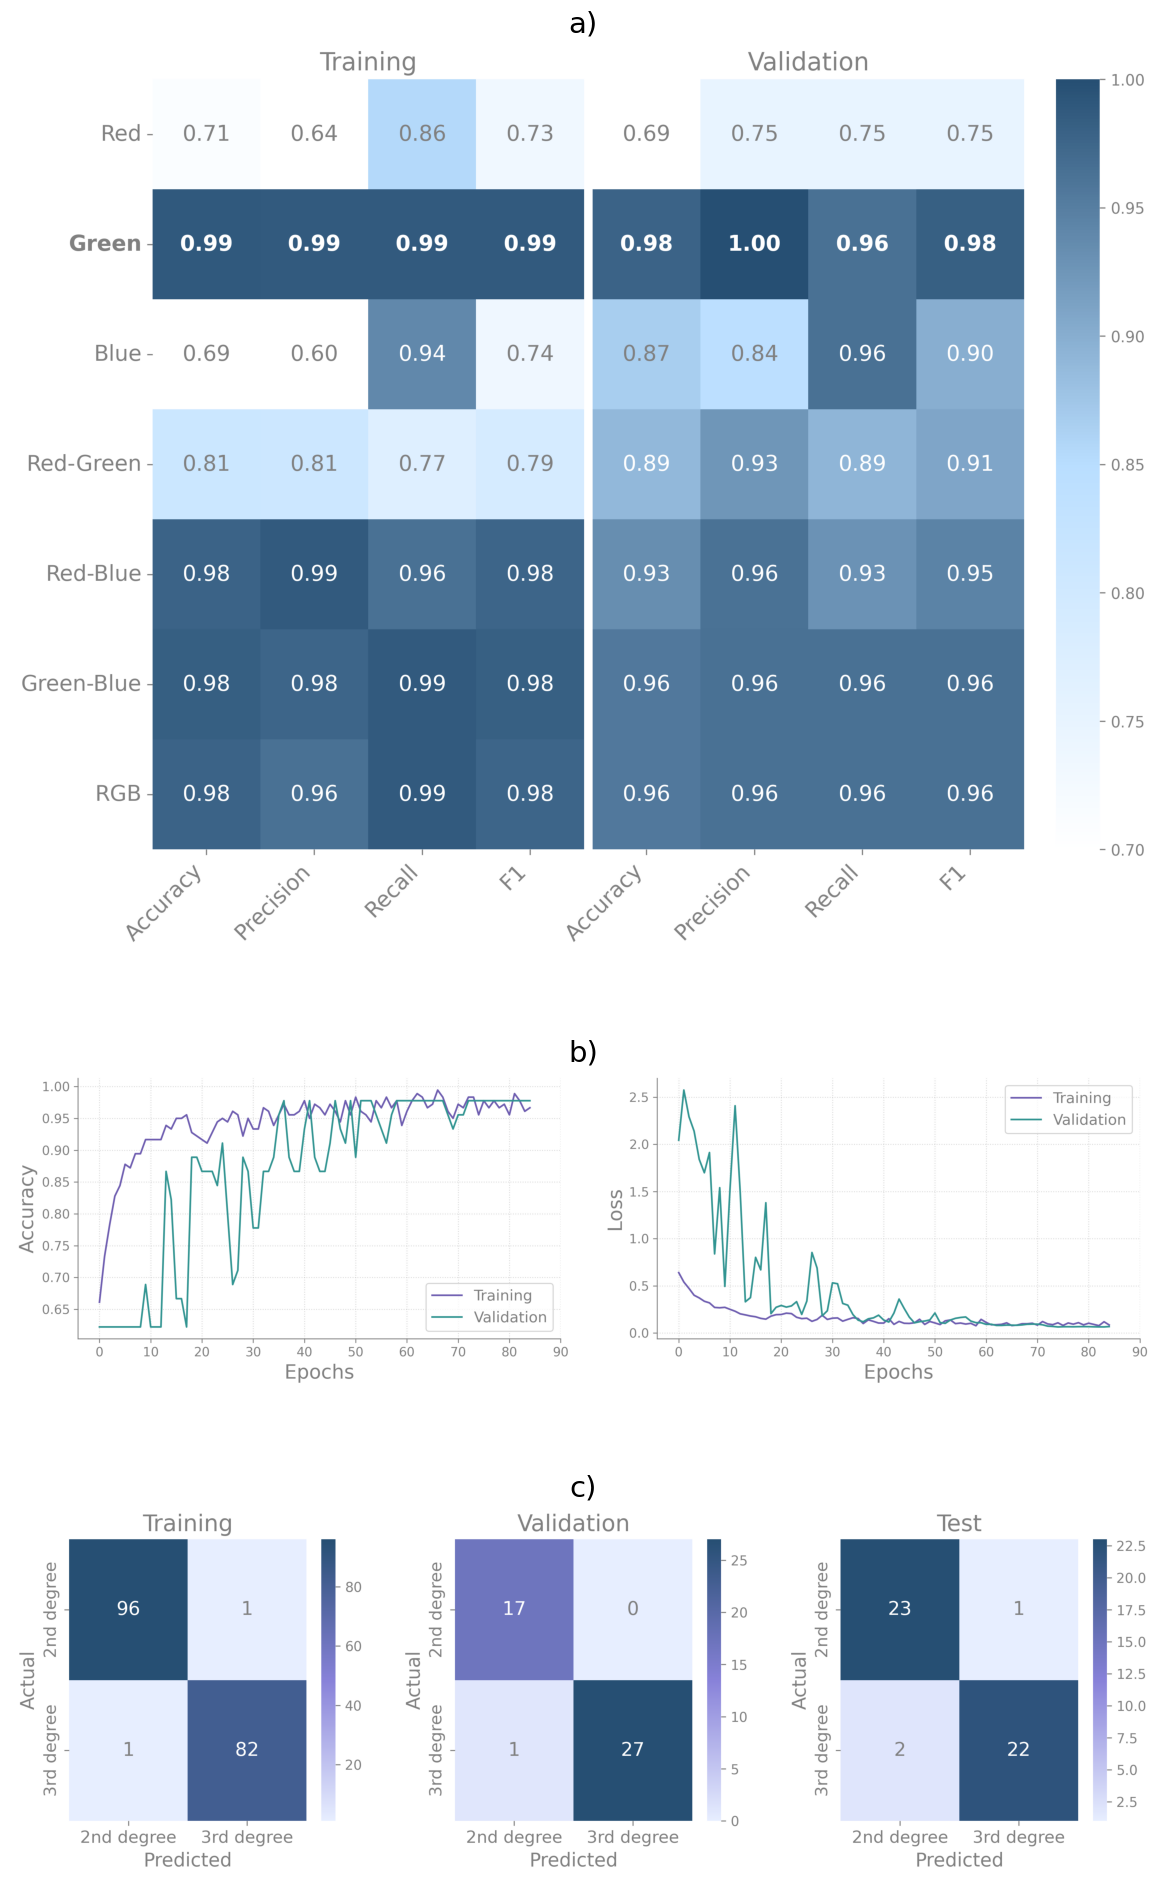

In [20]:
#Load previously generated figures
img_a = cv2.imread('../figures/3a_heatmap_channel_analysis.png')
img_b = cv2.imread('../figures/3b_accuracy_loss.png')
img_c = cv2.imread('../figures/3c_confusion_matrix_train_val_test.png')

#Retrieve image dimensions (height and width)
h1, w1 = img_a.shape[:2]
h2, w2 = img_b.shape[:2]
h3, w3 = img_c.shape[:2]

#Compute aspect ratios (height / width) to preserve proportional scaling
ratio_a = h1 / w1
ratio_b = h2 / w2
ratio_c = h3 / w3
ratios = [ratio_a, ratio_b, ratio_c]

#Create a vertically stacked figure using height ratios so that each panel maintains its original aspect proportion
fig, ax= plt.subplots(3, 1, figsize=(12, 19), gridspec_kw={'height_ratios': ratios})

#(a) Channel combination performance heatmap
ax[0].imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB))
ax[0].set_title('a)', fontsize='21')
ax[0].axis('off')

#(b) Learning curves
ax[1].imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
ax[1].set_title('b)', fontsize='21')
ax[1].axis('off')

#(c) Confusion matrices across dataset splits
ax[2].imshow(cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB))
ax[2].set_title('c)', fontsize='21')
ax[2].axis('off')

#Adjust layout and save figure
plt.tight_layout(h_pad=6.0)
plt.savefig('../figures/figure_3.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure 4. Comparison of the evaluation metrics between our model and the transfer learning models

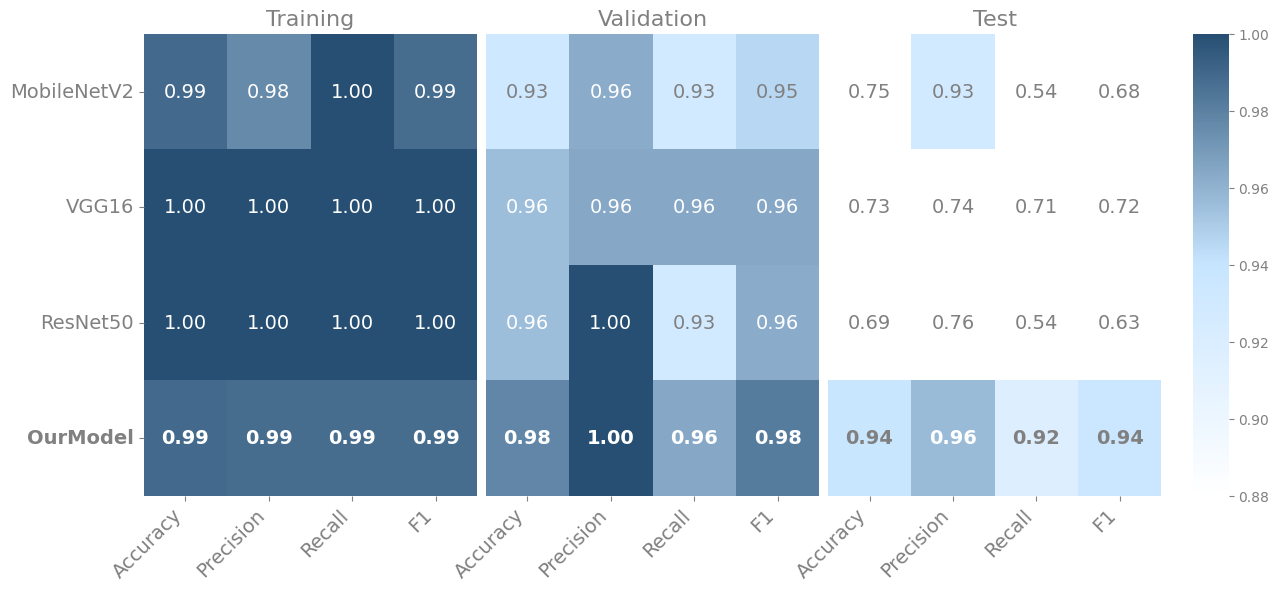

In [21]:
df = pd.read_csv('../data/results/model_metrics.csv') #Load the evaluation metrics of the transfer learning models and the proposed model

metrics = ['Accuracy', 'Precision', 'Recall', 'F1'] #Define the evaluation metrics

#Generate column names corresponding to training, validation and test results
train_metrics = [f'{m} Training' for m in metrics]
val_metrics = [f'{m} Validation' for m in metrics]
test_metrics = [f'{m} Test' for m in metrics]

#Extract metric values from the df as numpy arrays
data_train = df[train_metrics].values
data_val = df[val_metrics].values
data_test = df[test_metrics].values

#Retrieve model configuration names (each row corresponds to one trained model)
model_names = df['Model'].values

#Define a custom color gradient for heatmap visualization
colors = ['#ffffff', '#c7e5ff', '#264f73']
custom_cmap = LinearSegmentedColormap.from_list('custom_blue', colors)

#Create figure with GridSpec layout (three heatmaps of equal width and a dedicated axis for the colorbar)
fig = plt.figure(figsize=(14, 6))

gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.035], wspace=0.06) #Main grid: heatmaps + colorbar
gs_hm = gs[0].subgridspec(1, 3, wspace=0.025) #Grid only for heatmaps (controls their separation)

ax1 = fig.add_subplot(gs_hm[0]) #Training metrics heatmap
ax2 = fig.add_subplot(gs_hm[1]) #Validation metrics heatmap
ax3 = fig.add_subplot(gs_hm[2]) #Test metrics heatmap
cax = fig.add_subplot(gs[1]) #Dedicated axis for the shared colorbar

#Training
hm_train = sns.heatmap(data_train, annot=True, fmt='.2f', cmap=custom_cmap, vmin=0.88, vmax=1.0,
                       xticklabels=metrics, yticklabels=model_names, ax=ax1, cbar=False, annot_kws={'size': 14})
ax1.set_title('Training', fontsize=16, color='gray')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=14, color='gray')
adjust_annotation_colors(hm_train, ax1, data_train, threshold=0.8, light_color='white', dark_color='gray')
best_model_bold('OurModel', model_names, ax1, hm_train, n_cols=len(metrics))

#Validation
hm_val = sns.heatmap(data_val, annot=True, fmt='.2f', cmap=custom_cmap, vmin=0.88, vmax=1.0,
                     xticklabels=metrics, yticklabels=False, ax=ax2, cbar=False, annot_kws={'size': 14})
ax2.set_title('Validation', fontsize=16, color='gray')
adjust_annotation_colors(hm_val, ax2, data_val, threshold=0.8, light_color='white', dark_color='gray')
best_model_bold('OurModel', model_names, ax2, hm_val, n_cols=len(metrics))

#Test
hm_test = sns.heatmap(data_test, annot=True, fmt='.2f', cmap=custom_cmap, vmin=0.88, vmax=1.0,
                      xticklabels=metrics, yticklabels=False, ax=ax3, cbar_ax=cax, annot_kws={'size': 14})
ax3.set_title('Test', fontsize=16, color='gray')
adjust_annotation_colors(hm_test, ax3, data_test, threshold=0.8, light_color='white', dark_color='gray')
best_model_bold('OurModel', model_names, ax3, hm_test, n_cols=len(metrics))

#Apply consistent formatting to to all heatmaps
for ax in (ax1, ax2, ax3):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14, color='gray')
    ax.tick_params(axis='both', color='gray')

#Save figure
plt.savefig('../figures/figure_4.png', dpi=300, bbox_inches='tight')
plt.show()